In [1]:
import jax
import jax.numpy as jnp
import numpy as np # get rid of this eventually
import argparse
from jax import jit
from jax.experimental.ode import odeint
from functools import partial # reduces arguments to function by making some subset implicit

from jax.example_libraries import stax
from jax.example_libraries import optimizers

import os, sys, time
sys.path.append('..')

In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [3]:
sys.path.append('../experiment_nonlinear/')

from lnn import lagrangian_eom_rk4, lagrangian_eom, unconstrained_eom, raw_lagrangian_eom
from models import mlp as make_mlp

In [4]:
sys.path.append('../hyperopt_nonlinear')
from HyperparameterSearch import learned_dynamics
from HyperparameterSearch import extended_mlp

In [5]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

In [6]:
from data import get_trajectory
from data import get_trajectory_analytic
from physics_nonlinear import analytical_fn

vfnc = jax.jit(jax.vmap(analytical_fn))
vget = partial(jax.jit, backend='cpu')(jax.vmap(partial(get_trajectory_analytic, mxsteps=100), (0, None), 0))

### Now, let's load the best model. To generate more models, see the code below.

In [7]:
import pickle as pkl

In [8]:
args = ObjectView({'dataset_size': 1,
                    'fps': 1000,
                    'samples': 2,
                    'num_epochs': 80000,
                    'seed': 0,
                    'loss': 'l1',
                    'act': 'softplus',
                    'hidden_dim': 600,
                    'output_dim': 1,
                    'layers': 4,
                    'n_updates': 1,
                    'lr': 0.001,
                    'lr2': 2e-05,
                    'dt': 0.001,
                    'model': 'gln',
                    'batch_size': 512,
                    'l2reg': 5.7e-07,
})

rng = jax.random.PRNGKey(args.seed)

In [9]:
from jax.experimental.ode import odeint
from HyperparameterSearch import new_get_dataset
from matplotlib import pyplot as plt

In [10]:
vfnc = jax.jit(jax.vmap(analytical_fn, 0, 0))
vget = partial(jax.jit, backend='cpu')(jax.vmap(partial(get_trajectory_analytic, mxsteps=100), (0, None), 0))
minibatch_per = 2000
batch = 512

@jax.jit
def get_derivative_dataset(rng):
    # randomly sample inputs
    y0 = jnp.concatenate([
        (jax.random.uniform(rng, (batch*minibatch_per, 1))-0.5)*0.5,
        (jax.random.uniform(rng+1, (batch*minibatch_per, 1))-0.5)*0.1
    ], axis=1)
    
    return y0, vfnc(y0)

In [11]:
best_params = None
best_loss = np.inf

In [12]:
from itertools import product

In [13]:
import HyperparameterSearch
from jax.tree_util import tree_flatten
from HyperparameterSearch import make_loss, train
from copy import deepcopy as copy
from jax.tree_util import tree_flatten

init_random_params, nn_forward_fn = extended_mlp(args)
HyperparameterSearch.nn_forward_fn = nn_forward_fn
_, init_params = init_random_params(rng+1, (-1, 2))
rng += 1
model = (nn_forward_fn, init_params)
opt_init, opt_update, get_params = optimizers.adam(args.lr)
opt_state = opt_init([[l2/200.0 for l2 in l1] for l1 in init_params])

@jax.jit
def loss(params, batch, l2reg):
    state, targets = batch#_rk4
    leaves, _ = tree_flatten(params)
    l2_norm = sum(jnp.vdot(param, param) for param in leaves)
    preds = jax.vmap(partial(raw_lagrangian_eom,learned_dynamics(params)))(state)
    return jnp.sum(jnp.abs(preds - targets)) + l2reg*l2_norm/args.batch_size

@jax.jit
def update_derivative(i, opt_state, batch, l2reg):
    params = get_params(opt_state)
    param_update = jax.grad(lambda *args: loss(*args)/len(batch), 0)(params, batch, l2reg)
    params = get_params(opt_state)
    return opt_update(i, param_update, opt_state), params


best_small_loss = np.inf
(nn_forward_fn, init_params) = model
iteration = 0
total_epochs = 300
minibatch_per = 2000
train_losses, test_losses = [], []

lr = 1e-5 #1e-3

import math
final_div_factor=1e4

#OneCycleLR:
@jax.jit
def OneCycleLR(pct):
    #Rush it:
    start = 0.2 #0.2
    pct = pct * (1-start) + start
    high, low = lr, lr/final_div_factor
    scale = 1.0 - (jnp.cos(2 * jnp.pi * pct) + 1)/2
    return low + (high - low)*scale
    
from lnn import custom_init
opt_init, opt_update, get_params = optimizers.adam( OneCycleLR )
init_params = custom_init(init_params, seed=0)

opt_state = opt_init(init_params)
bad_iterations = 0
print(lr)

1e-05


Idea: add identity before inverse:

# Let's train it:

In [14]:
rng = jax.random.PRNGKey(0)

In [15]:
epoch = 0

In [16]:
batch_data = get_derivative_dataset(rng)[0][:1000], get_derivative_dataset(rng)[1][:1000]

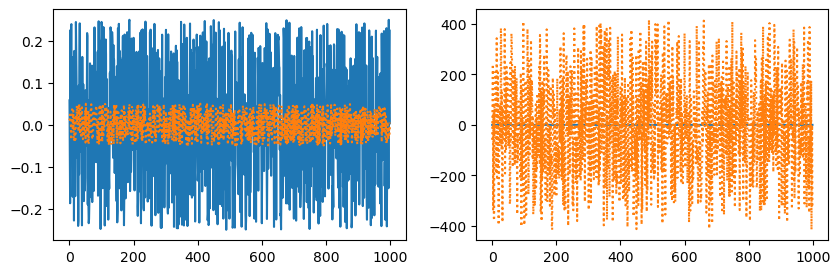

In [17]:
fig = plt.figure(figsize=(10,3))
plt.subplot(1,2,1); plt.plot(batch_data[0][:,0]); plt.plot(batch_data[0][:,1], ':')
plt.subplot(1,2,2); plt.plot(batch_data[1][:,0]); plt.plot(batch_data[1][:,1], ':')

In [18]:
loss(get_params(opt_state), batch_data, 0.0)/len(batch_data[0])

Array(158.06075, dtype=float32)

In [19]:
opt_state, params = update_derivative(0.0, opt_state, batch_data, 0.0)

In [20]:
from tqdm.notebook import tqdm

In [21]:
for epoch in tqdm(range(epoch, total_epochs)):
    epoch_loss = 0.0
    num_samples = 0
    all_batch_data = get_derivative_dataset(rng)
    for minibatch in range(minibatch_per):
        fraction = (epoch + minibatch/minibatch_per)/total_epochs
        batch_data = (all_batch_data[0][minibatch*batch:(minibatch+1)*batch], all_batch_data[1][minibatch*batch:(minibatch+1)*batch])
        rng += 10
        opt_state, params = update_derivative(fraction, opt_state, batch_data, 1e-6)
        cur_loss = loss(params, batch_data, 0.0)
        epoch_loss += cur_loss
        num_samples += batch
    closs = epoch_loss/num_samples
    print('epoch={} lr={} loss={}'.format(epoch, OneCycleLR(fraction), closs) )
    if closs < best_loss:
        best_loss = closs
        best_params = [[copy(jax.device_get(l2)) for l2 in l1] if len(l1) > 0 else () for l1 in params]

  0%|          | 0/300 [00:00<?, ?it/s]

epoch=0 lr=3.53541008735192e-06 loss=162.97085571289062
epoch=1 lr=3.6157020986138377e-06 loss=141.42095947265625
epoch=2 lr=3.6963824641134124e-06 loss=101.03868103027344
epoch=3 lr=3.7774289012304507e-06 loss=95.46640014648438
epoch=4 lr=3.858819127344759e-06 loss=111.6656265258789
epoch=5 lr=3.940529040846741e-06 loss=116.1906509399414
epoch=6 lr=4.022538178105606e-06 loss=114.5215072631836
epoch=7 lr=4.104820163775003e-06 loss=113.2177734375
epoch=8 lr=4.187354534224141e-06 loss=123.45147705078125
epoch=9 lr=4.270117187843425e-06 loss=113.89012145996094
epoch=10 lr=4.353084477770608e-06 loss=109.39025115966797
epoch=11 lr=4.436233666638145e-06 loss=112.0044937133789
epoch=12 lr=4.51954065283644e-06 loss=111.16202545166016
epoch=13 lr=4.60298360849265e-06 loss=111.74934387207031
epoch=14 lr=4.6865370677551255e-06 loss=151.98080444335938
epoch=15 lr=4.770179657498375e-06 loss=124.57440185546875
epoch=16 lr=4.85388682136545e-06 loss=115.57743835449219
epoch=17 lr=4.937634912494104e-06

epoch=283 lr=1.795898469936219e-07 loss=29.679033279418945
epoch=284 lr=1.580782935661773e-07 loss=29.684450149536133
epoch=285 lr=1.3792678998925112e-07 loss=29.693199157714844
epoch=286 lr=1.1914008979374557e-07 loss=29.679101943969727
epoch=287 lr=1.0172296782684498e-07 loss=29.67487144470215
epoch=288 lr=8.568138554210236e-08 loss=29.694414138793945
epoch=289 lr=7.10189169694786e-08 loss=29.683944702148438
epoch=290 lr=5.774152356252671e-08 loss=29.649005889892578
epoch=291 lr=4.5851585639411496e-08 loss=29.646947860717773
epoch=292 lr=3.535149062372511e-08 loss=29.634355545043945
epoch=293 lr=2.624600270451083e-08 loss=29.68060874938965
epoch=294 lr=1.85375093053608e-08 loss=29.66048240661621
epoch=295 lr=1.2227200585357423e-08 loss=29.670303344726562
epoch=296 lr=7.316268924029146e-09 loss=29.675905227661133
epoch=297 lr=3.808290127693681e-09 loss=29.65525245666504
epoch=298 lr=1.702072482956396e-09 loss=29.643375396728516
epoch=299 lr=9.999999717180685e-10 loss=29.66991043090820

Look at distribution of weights to make a better model?

In [22]:
pkl.dump( best_params, open('nonlinear_params.pt', 'wb') )

# best_params = pkl.load(open('nonlinear_params.pt', 'rb'))

### Make sure the args are the same:

The seed: [8, 8] looks pretty good! Set args.n_updates=3.

In [23]:
max_t = 1
new_dataset = new_get_dataset(jax.random.PRNGKey(2),
                              t_span=[0, max_t],
                              fps=1000, test_split=1.0,
                              unlimited_steps=False)


In [24]:
new_dataset['x'].shape

(999, 2)

In [25]:
t = new_dataset['x'][0, :]
tall = [jax.device_get(t)]
p = get_params(opt_state)

In [26]:
pred_tall = jax.device_get(odeint(
    partial(raw_lagrangian_eom, learned_dynamics(p)),
    t,
    np.linspace(0, max_t, num=new_dataset['x'].shape[0]),
    mxstep=100))

In [27]:
@jit
def kinetic_energy(state, m=1, a=1000, b=5000, c=90000):
    q, q_dot = state
    T = 0.5 * m * q_dot**2
    return T

@jit
def potential_energy(state, m=1, a=1000, b=5000, c=90000):
    q, q_dot = state
    V = 0.5*a*q**2 + 0.25*b*q**4 + (1/6)*c*q**6
    return V

### Let's compare energy for a variety of initial conditions:

In [28]:
import utils_data_identified
import utils_data

In [29]:
all_errors_LNN = []
all_errors_Bayes = []
store_error_LNN = []
store_error_Bayes = []
Pred_LNN = []
Pred_Bayes = []
Response = []

for i in tqdm(range(25)):
    max_t = 1
    fps = 100
    new_dataset = new_get_dataset(jax.random.PRNGKey(i), t_span=[0,max_t+(1/fps)], fps=fps,
                                  test_split=1.0, unlimited_steps=False)    
    t = new_dataset['x'][0, :]
    tall = [jax.device_get(t)]
    p = best_params
    pred_tall = jax.device_get(odeint(
        partial(raw_lagrangian_eom, learned_dynamics(p)),t,np.linspace(0, max_t, num=fps), mxstep=100))
    
    tparam = [1/fps, 0, max_t]
    param = [2*498.46, 4*1226.76, 6*14912.12]
    xt_nonlin_i, t_eval_nonlin_i = utils_data_identified.duffing_quintic(t, tparam, param)
    
    total_true_energy = (
        jax.vmap(kinetic_energy, 0, 0)(new_dataset['x'][:]) + \
        jax.vmap(potential_energy, 0, 0)(new_dataset['x'][:])
    )    
    total_predicted_energy = (
        jax.vmap(kinetic_energy, 0, 0)(pred_tall[:]) + \
        jax.vmap(potential_energy, 0, 0)(pred_tall[:])
    )
    total_proposed_energy = (
    jax.vmap(kinetic_energy, 0, 0)(xt_nonlin_i.T) + \
    jax.vmap(potential_energy, 0, 0)(xt_nonlin_i.T)
    )

    store_error_LNN.append(jnp.abs(total_predicted_energy-total_true_energy)/total_true_energy)
    store_error_Bayes.append(jnp.abs(total_proposed_energy-total_true_energy)/total_true_energy)
    
    cur_error_1 = np.linalg.norm(total_predicted_energy-total_true_energy)/np.linalg.norm(total_true_energy)
    cur_error_2 = np.linalg.norm(total_proposed_energy-total_true_energy)/np.linalg.norm(total_true_energy)
    
    all_errors_LNN.append(cur_error_1)
    all_errors_Bayes.append(cur_error_2)
    
    Pred_LNN.append( total_predicted_energy )
    Pred_Bayes.append( total_proposed_energy )
    Response.append( total_true_energy )
    print(i, '--LNN error--', jnp.average(jnp.array(all_errors_LNN)),
          'Bayes error', jnp.average(jnp.array(all_errors_Bayes)))

  0%|          | 0/25 [00:00<?, ?it/s]

0 --LNN error-- 0.77193093 Bayes error 0.006185389
1 --LNN error-- 0.57199895 Bayes error 0.0038012406
2 --LNN error-- 0.6395959 Bayes error 0.0050092954
3 --LNN error-- inf Bayes error 0.012503824
4 --LNN error-- inf Bayes error 0.010372007
5 --LNN error-- inf Bayes error 0.014714445
6 --LNN error-- inf Bayes error 0.013382346
7 --LNN error-- nan Bayes error 0.013422835
8 --LNN error-- nan Bayes error 0.015974106
9 --LNN error-- nan Bayes error 0.017598642
10 --LNN error-- nan Bayes error 0.016133303
11 --LNN error-- nan Bayes error 0.01515385
12 --LNN error-- nan Bayes error 0.014594965
13 --LNN error-- nan Bayes error 0.017066745
14 --LNN error-- nan Bayes error 0.016170613
15 --LNN error-- nan Bayes error 0.015828801
16 --LNN error-- nan Bayes error 0.015327098
17 --LNN error-- nan Bayes error 0.014991273
18 --LNN error-- nan Bayes error 0.014736263
19 --LNN error-- nan Bayes error 0.014869675
20 --LNN error-- nan Bayes error 0.014350183
21 --LNN error-- nan Bayes error 0.014125013

In [30]:
print('L2 error: LNN--, Proposed--', 100*np.mean(all_errors_LNN), 100*np.mean(all_errors_Bayes))

L2 error: LNN--, Proposed-- nan 1.7357904464006424


In [31]:
plt.rc('font', family='serif')
plt.rc('font', size=10)

## Plots made down here:

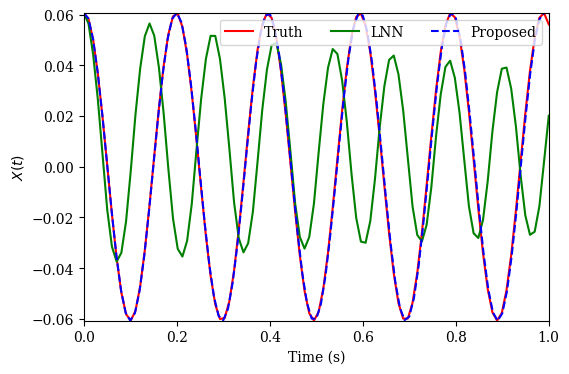

In [32]:
fig2 = plt.figure(figsize=(6,4))
plt.plot(np.linspace(0, max_t, fps), new_dataset['x'][:, 0], 'r', label='Truth')
plt.plot(np.linspace(0, max_t, fps), pred_tall[:, 0], color='green', label='LNN')
plt.plot(t_eval_nonlin_i, xt_nonlin_i[0,:], '--b', label='Proposed')
plt.ylabel(r'$X(t)$')
plt.xlabel('Time (s)')
plt.legend(ncol=3, loc=1)
plt.margins(0)

## Perform comparison with proposed Bayesian algorithm:

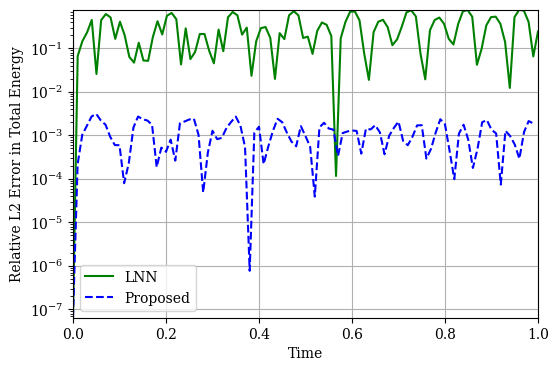

In [33]:
total_true_energy = (
    jax.vmap(kinetic_energy, 0, 0)(new_dataset['x'][:]) + \
    jax.vmap(potential_energy, 0, 0)(new_dataset['x'][:])
)
total_predicted_energy = (
    jax.vmap(kinetic_energy, 0, 0)(pred_tall[:]) + \
    jax.vmap(potential_energy, 0, 0)(pred_tall[:])
)
total_proposed_energy = (
    jax.vmap(kinetic_energy, 0, 0)(xt_nonlin_i.T) + \
    jax.vmap(potential_energy, 0, 0)(xt_nonlin_i.T)
)

fig3 = plt.figure(figsize=(6,4))
plt.plot( np.linspace(0, max_t, fps), jnp.abs(total_predicted_energy-total_true_energy)/total_true_energy, 
        'g' , label='LNN' )
plt.plot( t_eval_nonlin_i, jnp.abs(total_proposed_energy-total_true_energy)/total_true_energy,
        '--b', label='Proposed' )

plt.ylabel('Relative L2 Error in Total Energy')
plt.xlabel('Time')
plt.yscale('log')
plt.legend()
plt.margins(0)
plt.grid(True)

In [34]:
mean_LNN = np.mean(store_error_LNN, axis = 0)
std_LNN = np.std(store_error_LNN, axis = 0)

mean_Bayes = np.mean(store_error_Bayes, axis = 0) 
std_Bayes = np.std(store_error_Bayes, axis = 0)

In [35]:
plt.rc('font', size=36)

In [36]:
samples = 25

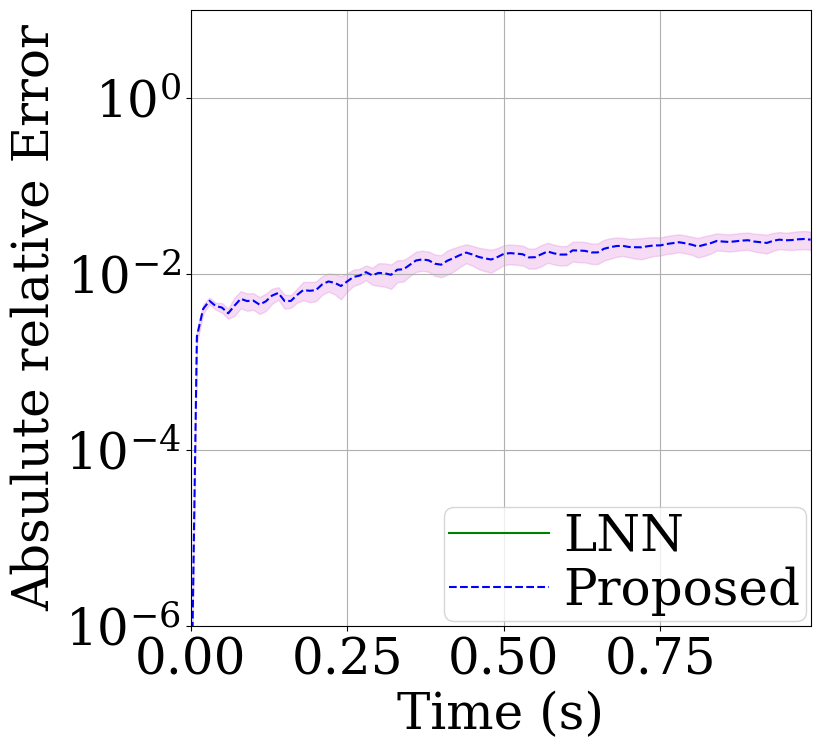

In [37]:
fig4 = plt.figure(figsize=(8,8))
plt.plot( np.linspace(0, max_t, fps), mean_LNN, 'g' , label='LNN' )
plt.fill_between(np.linspace(0, max_t, fps), mean_LNN-(1/np.sqrt(samples))*std_LNN, 
                                            mean_LNN +(1/np.sqrt(samples))*std_LNN, color='orange', alpha=0.25)

plt.plot( t_eval_nonlin_i, mean_Bayes, '--b', label='Proposed' )
plt.fill_between(t_eval_nonlin_i, mean_Bayes-(1/np.sqrt(samples))*std_Bayes, 
                                mean_Bayes + (1/np.sqrt(samples))*std_Bayes, color='orchid', alpha=0.25)

plt.ylabel('Absulute relative Error')
plt.xlabel('Time (s)')
plt.yscale('log')
plt.ylim([1e-6,10])
plt.legend(loc=4, labelspacing=0.1, borderaxespad=0.1, handletextpad=0.3, borderpad=0.1)
plt.margins(0)
plt.grid(True)

fig4.savefig('Error_nonlin_total_energy.pdf', format='pdf', dpi=600, bbox_inches='tight')

In [38]:
import scipy

In [39]:
scipy.io.savemat('Results_cqd_LNN_Bayes.mat', mdict={'store_error_LNN':store_error_LNN,
                                                    'store_error_Bayes':store_error_Bayes,
                                                    'Pred_LNN':Pred_LNN, 
                                                    'Pred_Bayes':Pred_Bayes, 
                                                    'Response':Response, })
